In [1]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from sklearn.metrics import roc_curve, auc
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from keras import layers, models, regularizers   # Import models here
from keras.callbacks import EarlyStopping

In [16]:
print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.5.1


In [2]:
background = np.load('Datasets/background.npz')['data']
bbh = np.load('Datasets/bbh_for_challenge.npy')
sglf = np.load('Datasets/sglf_for_challenge.npy')


In [18]:
background.shape, bbh.shape, sglf.shape

((100000, 2, 200), (100000, 2, 200), (100000, 2, 200))

# CNN 

In [3]:
# Transpose the datasets to match the required shape (N, 200, 2)
background = background.transpose(0, 2, 1)  # Shape: (100000, 200, 2)
bbh = bbh.transpose(0, 2, 1)                # Shape: (100000, 200, 2)
sglf = sglf.transpose(0, 2, 1)              # Shape: (100000, 200, 2)

# Combine datasets
X = np.concatenate([background, bbh, sglf], axis=0)  # Shape: (300000, 200, 2)

# Create labels: 0 for background, 1 for BBH, 2 for SGJF
y = np.concatenate([
    np.zeros(background.shape[0], dtype=int),  # Shape: (100000,)
    np.ones(bbh.shape[0], dtype=int),          # Shape: (100000,)
    np.full(sglf.shape[0], 2, dtype=int)       # Shape: (100000,)
])

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the training set into training (90%) and validation (10%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


In [4]:
from tensorflow.keras import layers, models, regularizers

input_shape = (200, 2)

model = models.Sequential([
    layers.Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=input_shape, 
                  kernel_regularizer=regularizers.l2(0.1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=32, kernel_size=3, activation='relu', 
                  kernel_regularizer=regularizers.l2(0.1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=64, kernel_size=3, activation='relu', 
                  kernel_regularizer=regularizers.l2(0.1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    # Change the output layer to softmax for multi-class classification
    layers.Dense(3, activation='softmax')  # 3 classes: background, BBH, SGJF
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


/Users/rebeccachen/miniforge3/envs/dsc80/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 198, 16)        │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 99, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 97, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 48, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 46, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1472)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       188,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 196,819 (768.82 KB)

 Trainable params: 196,819 (768.82 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Train the model
history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val), 
    epochs=20, 
    batch_size=64
)

Epoch 1/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.8294 - loss: 1.3658 - val_accuracy: 0.9075 - val_loss: 0.5332
Epoch 2/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9072 - loss: 0.5182 - val_accuracy: 0.9295 - val_loss: 0.4402
Epoch 3/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9158 - loss: 0.4603 - val_accuracy: 0.9345 - val_loss: 0.4058
Epoch 4/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9177 - loss: 0.4288 - val_accuracy: 0.9356 - val_loss: 0.3779
Epoch 5/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9205 - loss: 0.4076 - val_accuracy: 0.9356 - val_loss: 0.3652
Epoch 6/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.9217 - loss: 0.3964 - val_accuracy: 0.9384 - val_loss: 0.3510
Epoch 7/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.9228 - loss: 0.3860 - val_accuracy: 0.9243 - val_loss: 0.3671
Epoch 8/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.9241 - loss: 0

In [6]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9292 - loss: 0.3294
Test Loss: 0.32614102959632874, Test Accuracy: 0.9312000274658203


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


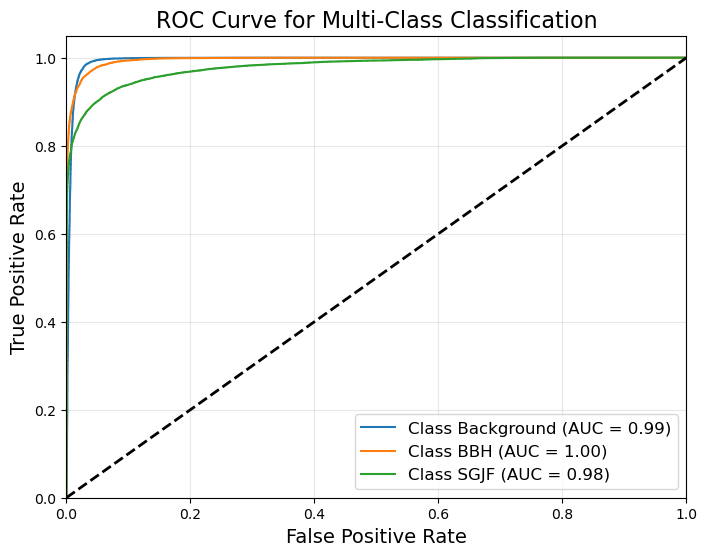

In [8]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_multiclass(model, X_test, y_test, class_labels):
    """
    Plots the ROC curve for a multi-class classification model.
    
    Parameters:
    - model: Trained Keras model.
    - X_test: Test data (features).
    - y_test: Test data (labels).
    - class_labels: List of class labels.
    """
    # Binarize the labels for multi-class ROC curve computation
    y_test_bin = label_binarize(y_test, classes=range(len(class_labels)))
    
    # Get the predicted probabilities for each class
    y_score = model.predict(X_test)
    
    # Compute ROC curve and AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(class_labels)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot the ROC curves
    plt.figure(figsize=(8, 6))
    for i, label in enumerate(class_labels):
        plt.plot(fpr[i], tpr[i], label=f"Class {label} (AUC = {roc_auc[i]:.2f})")
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.title("ROC Curve for Multi-Class Classification", fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

# Example usage:
class_labels = ['Background', 'BBH', 'SGJF']
plot_roc_multiclass(model, X_test, y_test, class_labels)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


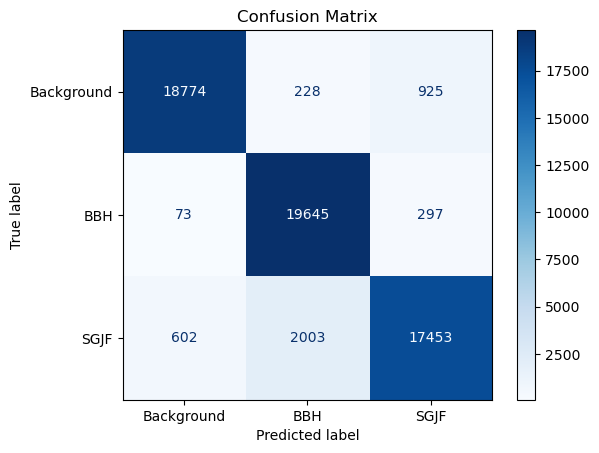

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, X_test, y_test, class_labels):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

class_labels = ['Background', 'BBH', 'SGJF']
plot_confusion_matrix(model, X_test, y_test, class_labels)
